<a href="https://colab.research.google.com/github/Gbemi123/DCGAN-for-generating-pokemon/blob/main/GANs_generating_Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversial Networks

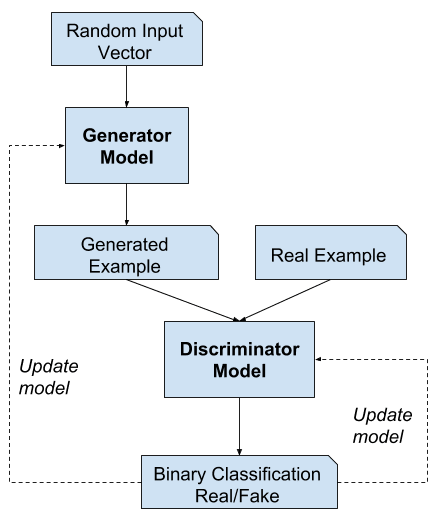

## Import Libraries

In [1]:
import numpy as np 
import random
import torch.nn as nn
import torch
from torch.utils.data.dataloader import DataLoader
import torchvision.datasets as datasets
import torchvision
import matplotlib.pyplot as plt 
import PIL.Image as Image
import torch.functional as F
import pandas as  pd
import torchvision.transforms as T
from torchvision.utils import make_grid
import os
import glob
import cv2
from pathlib import Path

In [2]:
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Getting the Pokemon Fashion dataset

In [3]:

!pip install -q kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list


ref                                                           title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                         Spotify and Youtube                              9MB  2023-03-20 15:43:25           2691        110  1.0              
usamabuttar/world-happiness-report-2005-present               World Happiness Report, 2005-Present           123KB  2023-03-25 17:38:26            912         27  1.0              
dgoenrique/netflix-movies-and-tv-shows                        Netflix Movies and TV Shows                      2MB  2023-03-13 18:49:00           1807         51  1.0              
rajkumarpandey02/list-of-countries-by-gdp-sector-composition  List of Countries by GDP Sector C

In [4]:
! kaggle datasets download vishalsubbiah/pokemon-images-and-types

100% 2.47M/2.47M [00:00<00:00, 4.71MB/s]
100% 2.47M/2.47M [00:00<00:00, 4.04MB/s]


In [5]:
! unzip /content/pokemon-images-and-types.zip

Archive:  /content/pokemon-images-and-types.zip
  inflating: images/images/abomasnow.png  
  inflating: images/images/abra.png  
  inflating: images/images/absol.png  
  inflating: images/images/accelgor.png  
  inflating: images/images/aegislash-blade.png  
  inflating: images/images/aerodactyl.png  
  inflating: images/images/aggron.png  
  inflating: images/images/aipom.png  
  inflating: images/images/alakazam.png  
  inflating: images/images/alomomola.png  
  inflating: images/images/altaria.png  
  inflating: images/images/amaura.png  
  inflating: images/images/ambipom.png  
  inflating: images/images/amoonguss.png  
  inflating: images/images/ampharos.png  
  inflating: images/images/anorith.png  
  inflating: images/images/araquanid.jpg  
  inflating: images/images/arbok.png  
  inflating: images/images/arcanine.png  
  inflating: images/images/arceus.png  
  inflating: images/images/archen.png  
  inflating: images/images/archeops.png  
  inflating: images/images/ariados.png 

In [6]:

image_size=64
prepare_imgs = torchvision.transforms.Compose([    
      torchvision.transforms.Resize(image_size), 
      torchvision.transforms.CenterCrop(image_size), # smaller sized imagaes give faster results
      torchvision.transforms.ToTensor(), 
      torchvision.transforms.Normalize((0.5, 0.5, 0.5) , (0.5, 0.5, 0.5 )), # Normalise to get data in range
  ])
  
 

In [7]:
def pil_loader(path, mode='RGB'):
  with open(path, 'rb') as f:
    img =Image.open(f)
    return img.convert(mode)
    

In [8]:
dataset = torchvision.datasets.ImageFolder('/content/images', loader= lambda path: pil_loader(path,mode='RGB'),transform = prepare_imgs)

In [9]:
batch_size =16
workers=2
train_loader = DataLoader(dataset, batch_size =batch_size, shuffle= True, num_workers=workers)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


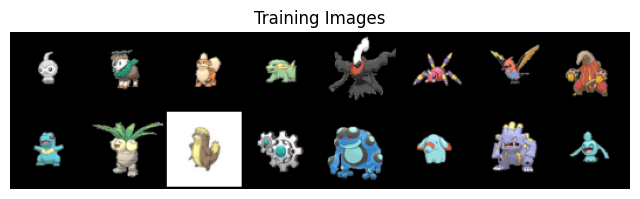

In [10]:
# Showing the data

real, labels = next(iter(train_loader)) 
plt.figure(figsize= (8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(make_grid(real, padding=2,normalize=True).permute(1,2,0).clip(0,1))



## To apply weights: 
###### From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [11]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Creating the Generator

In [13]:
class Generator(nn.Module):
  def __init__(self,ngpu):
    super(Generator,self).__init__()
  
    self.gen_model=nn.Sequential(
        #1st layer convolution (output size =64*8 x4 x4)
        nn.ConvTranspose2d(in_channels=100, out_channels=64*8, kernel_size=4,stride=1, padding=0, bias=False),
        nn.BatchNorm2d(num_features=64*8),
        nn.ReLU(True), 
        
        #2nd Layer (output=(64*4)x8x8)
        nn.ConvTranspose2d(in_channels=64*8, out_channels=64*4, kernel_size=4,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=64*4),
        nn.ReLU(True), 
        
        #3rd Layer(output =(64*2)x16x16)
        nn.ConvTranspose2d(in_channels=64*4, out_channels=64*2, kernel_size=4,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=64*2),
        nn.ReLU(True),

        #4th layer(output= 64 x32x32)
        nn.ConvTranspose2d(in_channels=64 *2, out_channels=64, kernel_size=4,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(True),  
                
        #5th layer (output =3x64x64)
        nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4,stride=2, padding=1, bias=False),
        nn.Tanh()
    )


  def forward(self, x):

    return self.gen_model(x)

In [14]:
ngpu=1
generator =Generator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.

generator.apply(weights_init)

# Print the model
print(generator)

Generator(
  (gen_model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

## Creating the discriminator model

In [15]:

class Discriminator(nn.Module):
  def __init__(self,ngpu):
    super(Discriminator, self).__init__()

    self.dis_model=nn.Sequential(
        #1st layer (output =3x64x64)
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4,stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True), 
         

        #2nd Layer 
        nn.Conv2d(in_channels=64, out_channels=64*2, kernel_size=4,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64*2),
        nn.LeakyReLU(0.2, inplace=True), 

        #3rd Layer
        nn.Conv2d(in_channels=64*2, out_channels=64*4, kernel_size=4,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64*4),
        nn.LeakyReLU(0.2, inplace=True), 

        #4th layer
        nn.Conv2d(in_channels=64*4, out_channels=64*8, kernel_size=4,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64*8),
        nn.LeakyReLU(0.2, inplace=True),  
        
        #5th layer 
        nn.Conv2d(in_channels=64*8, out_channels=1, kernel_size=4,stride=1, padding=0, bias=False), 
        nn.Sigmoid()


    )

  def forward(self, x):
    
    return self.dis_model(x)


In [16]:
# Handle multi-gpu if desired
discriminate =Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    discriminate = nn.DataParallel(discriminate, list(range(ngpu)))

discriminate.apply(weights_init)

# Print the model
discriminate

Discriminator(
  (dis_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Time to Trainnnn!!!


In [17]:
#learning rate, epochs and beta 1
lr=0.0002
epochs=200
beta1 =0.5

#loss function
loss_function =nn.BCELoss()

#Optimizers
optim_gen= torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_dis= torch.optim.Adam(discriminate.parameters(), lr=lr,betas=(beta1, 0.999))

#real and fake labls
real =1.
fake=0.

In [18]:
fixed_noise = torch.randn(16, 100, 1, 1, device=device)

In [19]:
discrim_loss=[]
gen_loss=[]
img_list =[]

iters=0
print("Starting Training Loop...")
for epoch in range(epochs):

  for n, data in enumerate(train_loader,0):
    # STEP 1: Training the disciminator 
    #.......................................................................................................
    #TRAINING WITH REAL DATA 
    #zero grad the discriminator

    discriminate.zero_grad()
    input_data =data[0].to(device)

    # get the batch_size 
    batch_S = input_data.size(0)

    # Make labels for all real images i.e. 1
    label=torch.full((batch_S,), real, dtype=torch.float, device=device)

    #Put the input image nto the discriminator model
    output = discriminate(input_data).view(-1) # to flatten the input

    #calculate loss bewteen the output and its label 
    loss_real =loss_function(output,label)
    
    #calculate the gradients
    loss_real.backward()
    D_x = output.mean().item()

#  .............................................................................................
    ##TRAINING WITH FAKE DATA
    #create noise as the latent vector 

    noise = torch.randn(batch_S, 100, 1,1).to(device)
    #fake_labels=torch.full((batch_S,), fake, dtype=torch.float,device=device)

    # Put noise into the generator 
    fake_generated_data =  generator(noise)
    label.fill_(fake)

    #put output from generatedor into the disciminator to classify as fake or real
    output = discriminate(fake_generated_data.detach()).view(-1) #to flatten

    #calculate loss
    loss_fake = loss_function(output, label)

    #calculate gradient 
    loss_fake.backward()
    D_G_z1=output.mean().item()

    #cmbine error of the discriminator as sum of the real and fake data error
    loss_discrim =loss_real + loss_fake

    #update the discriminator model 
    optim_dis.step()

    #..........................................................................................................
    #..........................................................................................................
    #STEP 2: Training the generator
    #........................................................................................................

    #Zero grad the discriminator
    generator.zero_grad()
    label.fill_(real)
    # Pass the fake data through the discriminator agin since its been updated
    output = discriminate(fake_generated_data).view(-1) #to flatten 

    # calculate loss of the  generator based on the output of the discrminator and real labels(1.)
    loss_gen =loss_function(output, label)

    #Calculate generator gradients
    loss_gen.backward()
    D_G_z2=output.mean().item()

    #update generator
    optim_gen.step()

    #print loss

    if n % 50 == 0:

       print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, n, len(train_loader),
                     loss_discrim.item(), loss_gen.item(), D_x, D_G_z1, D_G_z2))
       
    gen_loss.append(loss_gen.item())
    discrim_loss.append(loss_discrim.item())

    # check how model is doing through images 

    if  (iters % 500 == 0) or ((epoch == epochs-1) and (n == len(train_loader) -1)):
      with torch.no_grad():

          fake_gen =generator(fixed_noise).detach().cpu()

      img_list.append(make_grid(fake_gen, padding=2, normalize=True))

    iters +=1


Starting Training Loop...


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[0/200][0/51]	Loss_D: 1.8761	Loss_G: 5.7971	D(x): 0.4962	D(G(z)): 0.5554 / 0.0037
[0/200][50/51]	Loss_D: 0.0000	Loss_G: 34.7635	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1/200][0/51]	Loss_D: 0.0001	Loss_G: 34.7641	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/200][50/51]	Loss_D: 0.0000	Loss_G: 33.1428	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[2/200][0/51]	Loss_D: 0.0000	Loss_G: 33.5272	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/200][50/51]	Loss_D: 2.2828	Loss_G: 3.1215	D(x): 0.3997	D(G(z)): 0.0028 / 0.3373


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[3/200][0/51]	Loss_D: 2.8366	Loss_G: 12.1679	D(x): 0.9987	D(G(z)): 0.7220 / 0.0000
[3/200][50/51]	Loss_D: 0.2803	Loss_G: 5.3216	D(x): 0.9301	D(G(z)): 0.1433 / 0.0398


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[4/200][0/51]	Loss_D: 0.1320	Loss_G: 5.2352	D(x): 0.9512	D(G(z)): 0.0681 / 0.0258
[4/200][50/51]	Loss_D: 0.0476	Loss_G: 6.0985	D(x): 0.9781	D(G(z)): 0.0247 / 0.0052


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[5/200][0/51]	Loss_D: 3.2368	Loss_G: 0.8650	D(x): 0.0552	D(G(z)): 0.0084 / 0.5056
[5/200][50/51]	Loss_D: 1.4195	Loss_G: 1.5968	D(x): 0.4151	D(G(z)): 0.1174 / 0.2118


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[6/200][0/51]	Loss_D: 0.3968	Loss_G: 2.0565	D(x): 0.9966	D(G(z)): 0.3078 / 0.1465
[6/200][50/51]	Loss_D: 0.4441	Loss_G: 4.5085	D(x): 0.8692	D(G(z)): 0.1756 / 0.0120


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[7/200][0/51]	Loss_D: 0.0543	Loss_G: 4.5497	D(x): 0.9778	D(G(z)): 0.0306 / 0.0180
[7/200][50/51]	Loss_D: 1.0175	Loss_G: 0.9304	D(x): 0.7311	D(G(z)): 0.4421 / 0.4108


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[8/200][0/51]	Loss_D: 1.1635	Loss_G: 2.6322	D(x): 0.9992	D(G(z)): 0.6315 / 0.0849
[8/200][50/51]	Loss_D: 0.1845	Loss_G: 4.5265	D(x): 0.9972	D(G(z)): 0.1426 / 0.0130


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[9/200][0/51]	Loss_D: 0.1074	Loss_G: 4.3653	D(x): 0.9366	D(G(z)): 0.0377 / 0.0171
[9/200][50/51]	Loss_D: 5.4448	Loss_G: 1.1351	D(x): 0.0073	D(G(z)): 0.0663 / 0.4920


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/200][0/51]	Loss_D: 1.6500	Loss_G: 0.3957	D(x): 0.4629	D(G(z)): 0.4837 / 0.6841
[10/200][50/51]	Loss_D: 0.0732	Loss_G: 3.9963	D(x): 0.9768	D(G(z)): 0.0474 / 0.0348


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[11/200][0/51]	Loss_D: 3.6772	Loss_G: 0.3524	D(x): 0.0437	D(G(z)): 0.0669 / 0.7180
[11/200][50/51]	Loss_D: 0.0467	Loss_G: 4.5411	D(x): 0.9786	D(G(z)): 0.0247 / 0.0128


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[12/200][0/51]	Loss_D: 0.2570	Loss_G: 4.0388	D(x): 0.8007	D(G(z)): 0.0165 / 0.0222
[12/200][50/51]	Loss_D: 0.0350	Loss_G: 4.1186	D(x): 0.9885	D(G(z)): 0.0230 / 0.0199


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[13/200][0/51]	Loss_D: 3.1022	Loss_G: 1.1468	D(x): 0.0629	D(G(z)): 0.0361 / 0.3596
[13/200][50/51]	Loss_D: 0.0699	Loss_G: 3.5252	D(x): 0.9878	D(G(z)): 0.0549 / 0.0372


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[14/200][0/51]	Loss_D: 4.3871	Loss_G: 1.6145	D(x): 0.0312	D(G(z)): 0.0251 / 0.2269
[14/200][50/51]	Loss_D: 2.7952	Loss_G: 0.8257	D(x): 0.1108	D(G(z)): 0.0368 / 0.4827


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[15/200][0/51]	Loss_D: 0.4609	Loss_G: 1.3380	D(x): 0.9995	D(G(z)): 0.3531 / 0.2860
[15/200][50/51]	Loss_D: 0.9574	Loss_G: 0.9251	D(x): 0.6863	D(G(z)): 0.4178 / 0.4098


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[16/200][0/51]	Loss_D: 0.8916	Loss_G: 2.4454	D(x): 0.9997	D(G(z)): 0.5576 / 0.1056
[16/200][50/51]	Loss_D: 0.0983	Loss_G: 3.8984	D(x): 0.9939	D(G(z)): 0.0852 / 0.0356


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[17/200][0/51]	Loss_D: 1.8965	Loss_G: 1.4753	D(x): 0.1912	D(G(z)): 0.0468 / 0.2410
[17/200][50/51]	Loss_D: 1.5024	Loss_G: 1.9338	D(x): 0.2752	D(G(z)): 0.0504 / 0.1615


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[18/200][0/51]	Loss_D: 0.1888	Loss_G: 1.7935	D(x): 0.9992	D(G(z)): 0.1681 / 0.1849
[18/200][50/51]	Loss_D: 0.4159	Loss_G: 2.6955	D(x): 0.9988	D(G(z)): 0.3055 / 0.0741


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[19/200][0/51]	Loss_D: 0.4411	Loss_G: 2.6512	D(x): 0.7467	D(G(z)): 0.1280 / 0.0760
[19/200][50/51]	Loss_D: 0.6495	Loss_G: 2.3513	D(x): 0.6411	D(G(z)): 0.1230 / 0.1122


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[20/200][0/51]	Loss_D: 0.2671	Loss_G: 2.7405	D(x): 0.9971	D(G(z)): 0.2064 / 0.0824
[20/200][50/51]	Loss_D: 0.0409	Loss_G: 3.8832	D(x): 0.9978	D(G(z)): 0.0377 / 0.0225


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[21/200][0/51]	Loss_D: 0.0734	Loss_G: 3.6722	D(x): 0.9746	D(G(z)): 0.0460 / 0.0315
[21/200][50/51]	Loss_D: 1.5573	Loss_G: 2.2261	D(x): 0.3198	D(G(z)): 0.0255 / 0.1392


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[22/200][0/51]	Loss_D: 0.6199	Loss_G: 1.7629	D(x): 0.8581	D(G(z)): 0.3349 / 0.1946
[22/200][50/51]	Loss_D: 1.8341	Loss_G: 2.0264	D(x): 0.2577	D(G(z)): 0.0381 / 0.1954


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[23/200][0/51]	Loss_D: 0.5101	Loss_G: 1.9577	D(x): 0.9986	D(G(z)): 0.3567 / 0.2019
[23/200][50/51]	Loss_D: 0.0887	Loss_G: 4.4452	D(x): 0.9814	D(G(z)): 0.0631 / 0.0233


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[24/200][0/51]	Loss_D: 0.0467	Loss_G: 4.7541	D(x): 0.9791	D(G(z)): 0.0243 / 0.0118
[24/200][50/51]	Loss_D: 0.1378	Loss_G: 3.5298	D(x): 0.9030	D(G(z)): 0.0320 / 0.0356


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[25/200][0/51]	Loss_D: 0.0722	Loss_G: 3.2198	D(x): 0.9900	D(G(z)): 0.0594 / 0.0511
[25/200][50/51]	Loss_D: 0.0550	Loss_G: 4.1226	D(x): 0.9795	D(G(z)): 0.0335 / 0.0172


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[26/200][0/51]	Loss_D: 0.0435	Loss_G: 4.0287	D(x): 0.9963	D(G(z)): 0.0387 / 0.0227
[26/200][50/51]	Loss_D: 0.5947	Loss_G: 5.0732	D(x): 0.9953	D(G(z)): 0.2313 / 0.0119


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[27/200][0/51]	Loss_D: 0.4029	Loss_G: 3.1959	D(x): 0.7122	D(G(z)): 0.0439 / 0.0576
[27/200][50/51]	Loss_D: 0.1410	Loss_G: 4.3657	D(x): 0.9173	D(G(z)): 0.0514 / 0.0156


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[28/200][0/51]	Loss_D: 1.7455	Loss_G: 2.7372	D(x): 0.2556	D(G(z)): 0.0682 / 0.0818
[28/200][50/51]	Loss_D: 0.4374	Loss_G: 2.3044	D(x): 0.7090	D(G(z)): 0.0707 / 0.1165


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[29/200][0/51]	Loss_D: 0.1583	Loss_G: 3.2079	D(x): 0.9803	D(G(z)): 0.1225 / 0.0544
[29/200][50/51]	Loss_D: 0.4228	Loss_G: 3.2205	D(x): 0.7810	D(G(z)): 0.1064 / 0.1093


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[30/200][0/51]	Loss_D: 1.2063	Loss_G: 1.7650	D(x): 0.4308	D(G(z)): 0.1332 / 0.2447
[30/200][50/51]	Loss_D: 0.7817	Loss_G: 2.1797	D(x): 0.7239	D(G(z)): 0.2528 / 0.1982


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[31/200][0/51]	Loss_D: 0.1687	Loss_G: 3.1742	D(x): 0.9094	D(G(z)): 0.0673 / 0.0621
[31/200][50/51]	Loss_D: 0.8308	Loss_G: 2.0061	D(x): 0.7633	D(G(z)): 0.3839 / 0.1641


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[32/200][0/51]	Loss_D: 0.3795	Loss_G: 3.5238	D(x): 0.9261	D(G(z)): 0.2313 / 0.0417
[32/200][50/51]	Loss_D: 0.3473	Loss_G: 2.5647	D(x): 0.8005	D(G(z)): 0.1016 / 0.1058


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[33/200][0/51]	Loss_D: 1.0240	Loss_G: 4.2739	D(x): 0.9373	D(G(z)): 0.5001 / 0.0208
[33/200][50/51]	Loss_D: 1.9741	Loss_G: 4.4925	D(x): 0.8792	D(G(z)): 0.7652 / 0.0194


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[34/200][0/51]	Loss_D: 1.3841	Loss_G: 3.1753	D(x): 0.3557	D(G(z)): 0.0187 / 0.0734
[34/200][50/51]	Loss_D: 0.1759	Loss_G: 4.9235	D(x): 0.9489	D(G(z)): 0.1019 / 0.0111


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[35/200][0/51]	Loss_D: 1.2616	Loss_G: 2.0453	D(x): 0.3590	D(G(z)): 0.0264 / 0.2434
[35/200][50/51]	Loss_D: 0.2163	Loss_G: 3.7241	D(x): 0.8843	D(G(z)): 0.0814 / 0.0380


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[36/200][0/51]	Loss_D: 0.6928	Loss_G: 3.8844	D(x): 0.9645	D(G(z)): 0.4256 / 0.0233
[36/200][50/51]	Loss_D: 0.4168	Loss_G: 2.6593	D(x): 0.7673	D(G(z)): 0.1157 / 0.1110


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[37/200][0/51]	Loss_D: 0.2943	Loss_G: 2.7886	D(x): 0.9140	D(G(z)): 0.1683 / 0.1179
[37/200][50/51]	Loss_D: 0.8873	Loss_G: 2.8512	D(x): 0.7484	D(G(z)): 0.2702 / 0.0973


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[38/200][0/51]	Loss_D: 0.1513	Loss_G: 3.5781	D(x): 0.9244	D(G(z)): 0.0666 / 0.0402
[38/200][50/51]	Loss_D: 0.8446	Loss_G: 1.9908	D(x): 0.5342	D(G(z)): 0.1346 / 0.1531


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[39/200][0/51]	Loss_D: 0.2039	Loss_G: 2.9594	D(x): 0.9919	D(G(z)): 0.1692 / 0.0865
[39/200][50/51]	Loss_D: 0.0582	Loss_G: 5.1832	D(x): 0.9734	D(G(z)): 0.0303 / 0.0079


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[40/200][0/51]	Loss_D: 0.5562	Loss_G: 3.3218	D(x): 0.6360	D(G(z)): 0.0401 / 0.0716
[40/200][50/51]	Loss_D: 0.5055	Loss_G: 3.7798	D(x): 0.9978	D(G(z)): 0.3678 / 0.0265


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[41/200][0/51]	Loss_D: 0.7746	Loss_G: 4.3059	D(x): 0.5043	D(G(z)): 0.0209 / 0.0245
[41/200][50/51]	Loss_D: 0.6865	Loss_G: 1.9956	D(x): 0.7647	D(G(z)): 0.2514 / 0.1749


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[42/200][0/51]	Loss_D: 0.5016	Loss_G: 2.4003	D(x): 0.9084	D(G(z)): 0.2728 / 0.1061
[42/200][50/51]	Loss_D: 1.3280	Loss_G: 3.3410	D(x): 0.9898	D(G(z)): 0.6938 / 0.0372


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[43/200][0/51]	Loss_D: 0.2421	Loss_G: 4.0141	D(x): 0.8396	D(G(z)): 0.0549 / 0.0266
[43/200][50/51]	Loss_D: 0.3936	Loss_G: 1.5350	D(x): 0.8122	D(G(z)): 0.1595 / 0.2412


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[44/200][0/51]	Loss_D: 1.0313	Loss_G: 2.5735	D(x): 0.9217	D(G(z)): 0.5236 / 0.1005
[44/200][50/51]	Loss_D: 0.1184	Loss_G: 3.6498	D(x): 0.9399	D(G(z)): 0.0520 / 0.0382


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[45/200][0/51]	Loss_D: 0.6169	Loss_G: 2.9577	D(x): 0.7405	D(G(z)): 0.1887 / 0.0673
[45/200][50/51]	Loss_D: 2.3732	Loss_G: 0.6626	D(x): 0.2909	D(G(z)): 0.6217 / 0.5726


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[46/200][0/51]	Loss_D: 1.6023	Loss_G: 2.6665	D(x): 0.8277	D(G(z)): 0.6450 / 0.1593
[46/200][50/51]	Loss_D: 1.1176	Loss_G: 3.0371	D(x): 0.6545	D(G(z)): 0.3587 / 0.1061


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[47/200][0/51]	Loss_D: 1.5170	Loss_G: 3.0619	D(x): 0.3033	D(G(z)): 0.0169 / 0.0944
[47/200][50/51]	Loss_D: 0.3835	Loss_G: 3.9150	D(x): 0.7192	D(G(z)): 0.0370 / 0.0506


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[48/200][0/51]	Loss_D: 0.6533	Loss_G: 4.2368	D(x): 0.9507	D(G(z)): 0.3706 / 0.0208
[48/200][50/51]	Loss_D: 0.2067	Loss_G: 3.0884	D(x): 0.8674	D(G(z)): 0.0516 / 0.0597


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[49/200][0/51]	Loss_D: 1.3557	Loss_G: 2.6255	D(x): 0.9827	D(G(z)): 0.6419 / 0.0888
[49/200][50/51]	Loss_D: 0.5515	Loss_G: 2.4494	D(x): 0.8213	D(G(z)): 0.2736 / 0.1257


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[50/200][0/51]	Loss_D: 0.9664	Loss_G: 2.0671	D(x): 0.7119	D(G(z)): 0.3846 / 0.1729
[50/200][50/51]	Loss_D: 0.8096	Loss_G: 2.6965	D(x): 0.5910	D(G(z)): 0.1852 / 0.0921


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[51/200][0/51]	Loss_D: 0.3987	Loss_G: 2.7192	D(x): 0.7754	D(G(z)): 0.1162 / 0.1301
[51/200][50/51]	Loss_D: 1.1839	Loss_G: 3.7821	D(x): 0.9772	D(G(z)): 0.6782 / 0.0242


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[52/200][0/51]	Loss_D: 0.8749	Loss_G: 5.2993	D(x): 0.5021	D(G(z)): 0.0072 / 0.0090
[52/200][50/51]	Loss_D: 0.2814	Loss_G: 3.0817	D(x): 0.8326	D(G(z)): 0.0844 / 0.0628


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[53/200][0/51]	Loss_D: 0.2681	Loss_G: 3.1272	D(x): 0.9504	D(G(z)): 0.1829 / 0.0719
[53/200][50/51]	Loss_D: 0.1469	Loss_G: 3.0336	D(x): 0.9690	D(G(z)): 0.1051 / 0.0700


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[54/200][0/51]	Loss_D: 0.5184	Loss_G: 2.8722	D(x): 0.9119	D(G(z)): 0.3271 / 0.0678
[54/200][50/51]	Loss_D: 1.7237	Loss_G: 2.0414	D(x): 0.2522	D(G(z)): 0.1042 / 0.1631


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[55/200][0/51]	Loss_D: 0.7709	Loss_G: 4.1204	D(x): 0.9987	D(G(z)): 0.4448 / 0.0242
[55/200][50/51]	Loss_D: 0.1685	Loss_G: 4.6722	D(x): 0.8567	D(G(z)): 0.0096 / 0.0166


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[56/200][0/51]	Loss_D: 0.0556	Loss_G: 4.1955	D(x): 0.9711	D(G(z)): 0.0254 / 0.0299
[56/200][50/51]	Loss_D: 0.2480	Loss_G: 3.8628	D(x): 0.8844	D(G(z)): 0.0814 / 0.0501


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[57/200][0/51]	Loss_D: 0.2383	Loss_G: 2.6562	D(x): 0.9663	D(G(z)): 0.1757 / 0.0829
[57/200][50/51]	Loss_D: 1.6089	Loss_G: 2.6498	D(x): 0.9997	D(G(z)): 0.7545 / 0.0882


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[58/200][0/51]	Loss_D: 1.2020	Loss_G: 3.4421	D(x): 0.6540	D(G(z)): 0.4738 / 0.0371
[58/200][50/51]	Loss_D: 0.6951	Loss_G: 2.0558	D(x): 0.7187	D(G(z)): 0.2481 / 0.1391


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[59/200][0/51]	Loss_D: 0.3968	Loss_G: 2.8149	D(x): 0.8745	D(G(z)): 0.2060 / 0.1019
[59/200][50/51]	Loss_D: 0.8775	Loss_G: 4.4238	D(x): 0.7096	D(G(z)): 0.3924 / 0.0174


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[60/200][0/51]	Loss_D: 0.0664	Loss_G: 5.6382	D(x): 0.9573	D(G(z)): 0.0207 / 0.0094
[60/200][50/51]	Loss_D: 1.8382	Loss_G: 2.1561	D(x): 0.3617	D(G(z)): 0.2498 / 0.1973


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[61/200][0/51]	Loss_D: 1.5643	Loss_G: 2.9059	D(x): 0.6512	D(G(z)): 0.5875 / 0.0689
[61/200][50/51]	Loss_D: 0.0631	Loss_G: 5.2341	D(x): 0.9535	D(G(z)): 0.0149 / 0.0111


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[62/200][0/51]	Loss_D: 0.3429	Loss_G: 2.8892	D(x): 0.9740	D(G(z)): 0.2628 / 0.0607
[62/200][50/51]	Loss_D: 0.3877	Loss_G: 5.7706	D(x): 0.7167	D(G(z)): 0.0046 / 0.0053


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[63/200][0/51]	Loss_D: 0.2572	Loss_G: 3.9794	D(x): 0.8116	D(G(z)): 0.0307 / 0.0465
[63/200][50/51]	Loss_D: 0.3338	Loss_G: 2.3695	D(x): 0.9516	D(G(z)): 0.2301 / 0.1088


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[64/200][0/51]	Loss_D: 0.2460	Loss_G: 2.9079	D(x): 0.8799	D(G(z)): 0.1014 / 0.0639
[64/200][50/51]	Loss_D: 1.2852	Loss_G: 2.1646	D(x): 0.8174	D(G(z)): 0.6367 / 0.1381


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[65/200][0/51]	Loss_D: 0.2603	Loss_G: 3.4194	D(x): 0.9820	D(G(z)): 0.2053 / 0.0429
[65/200][50/51]	Loss_D: 1.6524	Loss_G: 6.3592	D(x): 0.9979	D(G(z)): 0.7635 / 0.0025


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[66/200][0/51]	Loss_D: 1.1811	Loss_G: 2.6464	D(x): 0.4470	D(G(z)): 0.1225 / 0.1091
[66/200][50/51]	Loss_D: 0.0233	Loss_G: 5.3963	D(x): 0.9878	D(G(z)): 0.0108 / 0.0049


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[67/200][0/51]	Loss_D: 0.0434	Loss_G: 4.6879	D(x): 0.9860	D(G(z)): 0.0282 / 0.0148
[67/200][50/51]	Loss_D: 0.2427	Loss_G: 2.7946	D(x): 0.9864	D(G(z)): 0.1906 / 0.0736


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[68/200][0/51]	Loss_D: 0.8172	Loss_G: 1.8491	D(x): 0.5765	D(G(z)): 0.1748 / 0.1766
[68/200][50/51]	Loss_D: 2.1886	Loss_G: 2.4887	D(x): 0.5984	D(G(z)): 0.7557 / 0.1196


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[69/200][0/51]	Loss_D: 0.2107	Loss_G: 4.1685	D(x): 0.9482	D(G(z)): 0.1367 / 0.0245
[69/200][50/51]	Loss_D: 0.3919	Loss_G: 2.9690	D(x): 0.9289	D(G(z)): 0.2230 / 0.0773


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[70/200][0/51]	Loss_D: 0.5918	Loss_G: 3.4716	D(x): 0.8426	D(G(z)): 0.2482 / 0.0675
[70/200][50/51]	Loss_D: 1.7948	Loss_G: 0.8161	D(x): 0.2321	D(G(z)): 0.0176 / 0.4889


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[71/200][0/51]	Loss_D: 1.7723	Loss_G: 2.5177	D(x): 0.9167	D(G(z)): 0.7206 / 0.1164
[71/200][50/51]	Loss_D: 0.3254	Loss_G: 3.7824	D(x): 0.9997	D(G(z)): 0.2470 / 0.0286


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[72/200][0/51]	Loss_D: 0.5829	Loss_G: 3.4672	D(x): 0.6413	D(G(z)): 0.0727 / 0.0623
[72/200][50/51]	Loss_D: 1.0902	Loss_G: 2.3077	D(x): 0.4378	D(G(z)): 0.0955 / 0.1270


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[73/200][0/51]	Loss_D: 0.5508	Loss_G: 2.1830	D(x): 0.8185	D(G(z)): 0.2600 / 0.1670
[73/200][50/51]	Loss_D: 0.1091	Loss_G: 5.0586	D(x): 0.9153	D(G(z)): 0.0142 / 0.0071


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[74/200][0/51]	Loss_D: 0.2803	Loss_G: 4.8188	D(x): 0.8211	D(G(z)): 0.0240 / 0.0194
[74/200][50/51]	Loss_D: 1.4281	Loss_G: 2.8651	D(x): 0.8631	D(G(z)): 0.5400 / 0.0766


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[75/200][0/51]	Loss_D: 0.5271	Loss_G: 3.2127	D(x): 0.7467	D(G(z)): 0.1863 / 0.0510
[75/200][50/51]	Loss_D: 1.0929	Loss_G: 4.2481	D(x): 0.8087	D(G(z)): 0.4732 / 0.0182


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[76/200][0/51]	Loss_D: 0.3713	Loss_G: 4.5463	D(x): 0.7228	D(G(z)): 0.0142 / 0.0154
[76/200][50/51]	Loss_D: 0.3524	Loss_G: 4.1968	D(x): 0.9943	D(G(z)): 0.2564 / 0.0331


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[77/200][0/51]	Loss_D: 0.3934	Loss_G: 3.5063	D(x): 0.7627	D(G(z)): 0.0609 / 0.0362
[77/200][50/51]	Loss_D: 0.7946	Loss_G: 3.4006	D(x): 0.9974	D(G(z)): 0.4527 / 0.0569


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[78/200][0/51]	Loss_D: 1.1793	Loss_G: 2.7171	D(x): 0.3858	D(G(z)): 0.0384 / 0.0996
[78/200][50/51]	Loss_D: 0.2070	Loss_G: 5.3490	D(x): 0.8226	D(G(z)): 0.0037 / 0.0083


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[79/200][0/51]	Loss_D: 1.3437	Loss_G: 2.8449	D(x): 0.8506	D(G(z)): 0.5979 / 0.1352
[79/200][50/51]	Loss_D: 0.3341	Loss_G: 4.0387	D(x): 0.9232	D(G(z)): 0.2055 / 0.0437


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[80/200][0/51]	Loss_D: 0.3524	Loss_G: 3.6200	D(x): 0.9986	D(G(z)): 0.2668 / 0.0400
[80/200][50/51]	Loss_D: 0.5658	Loss_G: 2.6386	D(x): 0.7495	D(G(z)): 0.2162 / 0.0729


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[81/200][0/51]	Loss_D: 0.4749	Loss_G: 4.1796	D(x): 0.6787	D(G(z)): 0.0106 / 0.0232
[81/200][50/51]	Loss_D: 0.0404	Loss_G: 7.1758	D(x): 0.9647	D(G(z)): 0.0022 / 0.0012


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[82/200][0/51]	Loss_D: 0.0135	Loss_G: 5.3889	D(x): 0.9967	D(G(z)): 0.0101 / 0.0074
[82/200][50/51]	Loss_D: 1.7408	Loss_G: 4.6264	D(x): 0.2850	D(G(z)): 0.0016 / 0.0165


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[83/200][0/51]	Loss_D: 0.2421	Loss_G: 1.9540	D(x): 0.8735	D(G(z)): 0.0881 / 0.2112
[83/200][50/51]	Loss_D: 0.1233	Loss_G: 3.4926	D(x): 0.9550	D(G(z)): 0.0715 / 0.0397


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[84/200][0/51]	Loss_D: 0.1374	Loss_G: 4.2151	D(x): 0.9241	D(G(z)): 0.0455 / 0.0299
[84/200][50/51]	Loss_D: 0.3891	Loss_G: 4.0361	D(x): 0.9970	D(G(z)): 0.2988 / 0.0203


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[85/200][0/51]	Loss_D: 0.0813	Loss_G: 4.5254	D(x): 0.9689	D(G(z)): 0.0476 / 0.0164
[85/200][50/51]	Loss_D: 0.5445	Loss_G: 3.9059	D(x): 0.8333	D(G(z)): 0.2361 / 0.0410


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[86/200][0/51]	Loss_D: 0.2173	Loss_G: 4.2186	D(x): 0.9765	D(G(z)): 0.1389 / 0.0414
[86/200][50/51]	Loss_D: 0.1820	Loss_G: 4.4795	D(x): 0.9921	D(G(z)): 0.1321 / 0.0137


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[87/200][0/51]	Loss_D: 0.0551	Loss_G: 5.4689	D(x): 0.9879	D(G(z)): 0.0403 / 0.0107
[87/200][50/51]	Loss_D: 0.2638	Loss_G: 4.1287	D(x): 0.8944	D(G(z)): 0.1249 / 0.0178


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[88/200][0/51]	Loss_D: 0.1017	Loss_G: 4.1431	D(x): 0.9366	D(G(z)): 0.0333 / 0.0263
[88/200][50/51]	Loss_D: 0.2959	Loss_G: 4.5987	D(x): 0.7697	D(G(z)): 0.0128 / 0.0168


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[89/200][0/51]	Loss_D: 0.0742	Loss_G: 3.4853	D(x): 0.9868	D(G(z)): 0.0571 / 0.0443
[89/200][50/51]	Loss_D: 0.6190	Loss_G: 4.4819	D(x): 0.7878	D(G(z)): 0.2257 / 0.0223


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[90/200][0/51]	Loss_D: 0.6446	Loss_G: 4.1175	D(x): 0.5796	D(G(z)): 0.0054 / 0.0328
[90/200][50/51]	Loss_D: 0.3145	Loss_G: 2.8670	D(x): 0.7688	D(G(z)): 0.0299 / 0.1178


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[91/200][0/51]	Loss_D: 0.5917	Loss_G: 2.2631	D(x): 0.6531	D(G(z)): 0.0419 / 0.1541
[91/200][50/51]	Loss_D: 1.1364	Loss_G: 3.5917	D(x): 0.5477	D(G(z)): 0.3410 / 0.0452


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[92/200][0/51]	Loss_D: 0.4392	Loss_G: 5.0284	D(x): 0.9283	D(G(z)): 0.2683 / 0.0098
[92/200][50/51]	Loss_D: 0.3920	Loss_G: 6.1962	D(x): 0.7939	D(G(z)): 0.0816 / 0.0082


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[93/200][0/51]	Loss_D: 0.4439	Loss_G: 2.5728	D(x): 0.7300	D(G(z)): 0.0643 / 0.1065
[93/200][50/51]	Loss_D: 1.4863	Loss_G: 6.0829	D(x): 0.2759	D(G(z)): 0.0012 / 0.0131


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[94/200][0/51]	Loss_D: 0.3112	Loss_G: 2.5008	D(x): 0.8782	D(G(z)): 0.1103 / 0.1039
[94/200][50/51]	Loss_D: 0.0245	Loss_G: 5.0146	D(x): 0.9933	D(G(z)): 0.0175 / 0.0151


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[95/200][0/51]	Loss_D: 0.0402	Loss_G: 4.4591	D(x): 0.9948	D(G(z)): 0.0337 / 0.0219
[95/200][50/51]	Loss_D: 0.0421	Loss_G: 5.4272	D(x): 0.9817	D(G(z)): 0.0229 / 0.0065


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[96/200][0/51]	Loss_D: 0.2471	Loss_G: 4.0385	D(x): 0.8536	D(G(z)): 0.0373 / 0.0425
[96/200][50/51]	Loss_D: 0.4117	Loss_G: 5.3452	D(x): 0.7478	D(G(z)): 0.0026 / 0.0100


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[97/200][0/51]	Loss_D: 0.1034	Loss_G: 3.3285	D(x): 0.9994	D(G(z)): 0.0949 / 0.0483
[97/200][50/51]	Loss_D: 0.5739	Loss_G: 5.8845	D(x): 0.9987	D(G(z)): 0.4069 / 0.0076


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[98/200][0/51]	Loss_D: 0.6410	Loss_G: 3.2774	D(x): 0.6659	D(G(z)): 0.1351 / 0.0713
[98/200][50/51]	Loss_D: 2.8748	Loss_G: 2.0993	D(x): 0.1554	D(G(z)): 0.0239 / 0.1800


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[99/200][0/51]	Loss_D: 1.1227	Loss_G: 7.5361	D(x): 0.9996	D(G(z)): 0.5853 / 0.0020
[99/200][50/51]	Loss_D: 0.7386	Loss_G: 3.7737	D(x): 0.9999	D(G(z)): 0.4868 / 0.0299


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[100/200][0/51]	Loss_D: 0.3836	Loss_G: 4.7196	D(x): 0.9974	D(G(z)): 0.2567 / 0.0176
[100/200][50/51]	Loss_D: 3.6651	Loss_G: 1.3208	D(x): 0.0389	D(G(z)): 0.0256 / 0.2917


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[101/200][0/51]	Loss_D: 1.0574	Loss_G: 4.7932	D(x): 1.0000	D(G(z)): 0.5356 / 0.0172
[101/200][50/51]	Loss_D: 0.4983	Loss_G: 3.7266	D(x): 0.6947	D(G(z)): 0.0600 / 0.0391


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[102/200][0/51]	Loss_D: 0.2116	Loss_G: 4.3180	D(x): 0.9988	D(G(z)): 0.1753 / 0.0233
[102/200][50/51]	Loss_D: 0.0450	Loss_G: 5.0160	D(x): 1.0000	D(G(z)): 0.0429 / 0.0133


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[103/200][0/51]	Loss_D: 0.0403	Loss_G: 4.7100	D(x): 0.9948	D(G(z)): 0.0338 / 0.0143
[103/200][50/51]	Loss_D: 0.0169	Loss_G: 5.2509	D(x): 0.9989	D(G(z)): 0.0155 / 0.0095


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[104/200][0/51]	Loss_D: 0.0253	Loss_G: 4.5773	D(x): 0.9999	D(G(z)): 0.0246 / 0.0162
[104/200][50/51]	Loss_D: 0.8332	Loss_G: 3.6545	D(x): 0.5413	D(G(z)): 0.0224 / 0.0422


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[105/200][0/51]	Loss_D: 0.0534	Loss_G: 3.7743	D(x): 0.9998	D(G(z)): 0.0503 / 0.0505
[105/200][50/51]	Loss_D: 0.4058	Loss_G: 3.4329	D(x): 0.8226	D(G(z)): 0.1627 / 0.0353


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[106/200][0/51]	Loss_D: 0.2754	Loss_G: 3.9609	D(x): 0.9999	D(G(z)): 0.2019 / 0.0300
[106/200][50/51]	Loss_D: 0.0392	Loss_G: 5.3677	D(x): 0.9948	D(G(z)): 0.0325 / 0.0103


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[107/200][0/51]	Loss_D: 1.7195	Loss_G: 2.3630	D(x): 0.3705	D(G(z)): 0.0491 / 0.1672
[107/200][50/51]	Loss_D: 0.0571	Loss_G: 4.8298	D(x): 1.0000	D(G(z)): 0.0525 / 0.0109


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[108/200][0/51]	Loss_D: 0.0943	Loss_G: 4.6911	D(x): 0.9908	D(G(z)): 0.0716 / 0.0135
[108/200][50/51]	Loss_D: 0.4139	Loss_G: 5.2824	D(x): 0.9997	D(G(z)): 0.3126 / 0.0120


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[109/200][0/51]	Loss_D: 0.1636	Loss_G: 5.6760	D(x): 1.0000	D(G(z)): 0.1375 / 0.0066
[109/200][50/51]	Loss_D: 0.0247	Loss_G: 4.9465	D(x): 0.9997	D(G(z)): 0.0238 / 0.0123


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[110/200][0/51]	Loss_D: 1.5309	Loss_G: 1.9003	D(x): 0.3313	D(G(z)): 0.0285 / 0.2028
[110/200][50/51]	Loss_D: 0.0379	Loss_G: 4.8976	D(x): 0.9995	D(G(z)): 0.0358 / 0.0104


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[111/200][0/51]	Loss_D: 0.0191	Loss_G: 5.1111	D(x): 0.9970	D(G(z)): 0.0159 / 0.0085
[111/200][50/51]	Loss_D: 0.0207	Loss_G: 5.3523	D(x): 0.9999	D(G(z)): 0.0199 / 0.0110


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[112/200][0/51]	Loss_D: 2.4858	Loss_G: 2.0018	D(x): 0.2159	D(G(z)): 0.0237 / 0.1984
[112/200][50/51]	Loss_D: 0.0378	Loss_G: 4.5726	D(x): 1.0000	D(G(z)): 0.0366 / 0.0146


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[113/200][0/51]	Loss_D: 0.1187	Loss_G: 4.3151	D(x): 1.0000	D(G(z)): 0.0877 / 0.0192
[113/200][50/51]	Loss_D: 3.8070	Loss_G: 1.8435	D(x): 0.0370	D(G(z)): 0.0155 / 0.3538


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[114/200][0/51]	Loss_D: 0.9424	Loss_G: 5.2724	D(x): 0.9994	D(G(z)): 0.5187 / 0.0165
[114/200][50/51]	Loss_D: 0.0135	Loss_G: 5.2553	D(x): 1.0000	D(G(z)): 0.0133 / 0.0076


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[115/200][0/51]	Loss_D: 0.0181	Loss_G: 5.1080	D(x): 0.9999	D(G(z)): 0.0175 / 0.0116
[115/200][50/51]	Loss_D: 0.0327	Loss_G: 5.2908	D(x): 1.0000	D(G(z)): 0.0315 / 0.0081


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[116/200][0/51]	Loss_D: 0.0235	Loss_G: 5.3248	D(x): 0.9964	D(G(z)): 0.0194 / 0.0102
[116/200][50/51]	Loss_D: 0.0214	Loss_G: 5.3518	D(x): 0.9999	D(G(z)): 0.0208 / 0.0101


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[117/200][0/51]	Loss_D: 0.0332	Loss_G: 4.5090	D(x): 0.9995	D(G(z)): 0.0318 / 0.0168
[117/200][50/51]	Loss_D: 0.1210	Loss_G: 4.0583	D(x): 1.0000	D(G(z)): 0.1055 / 0.0219


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[118/200][0/51]	Loss_D: 0.0499	Loss_G: 4.6343	D(x): 1.0000	D(G(z)): 0.0473 / 0.0176
[118/200][50/51]	Loss_D: 0.4095	Loss_G: 3.7497	D(x): 0.8671	D(G(z)): 0.2124 / 0.0285


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[119/200][0/51]	Loss_D: 0.0870	Loss_G: 4.0004	D(x): 1.0000	D(G(z)): 0.0812 / 0.0239
[119/200][50/51]	Loss_D: 0.7700	Loss_G: 4.1721	D(x): 0.8639	D(G(z)): 0.3600 / 0.0265


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[120/200][0/51]	Loss_D: 0.2872	Loss_G: 4.5456	D(x): 0.9998	D(G(z)): 0.2206 / 0.0136
[120/200][50/51]	Loss_D: 0.0477	Loss_G: 5.1980	D(x): 1.0000	D(G(z)): 0.0451 / 0.0090


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[121/200][0/51]	Loss_D: 0.0778	Loss_G: 4.8909	D(x): 0.9999	D(G(z)): 0.0710 / 0.0231
[121/200][50/51]	Loss_D: 0.0319	Loss_G: 4.8707	D(x): 1.0000	D(G(z)): 0.0312 / 0.0094


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[122/200][0/51]	Loss_D: 0.0520	Loss_G: 4.5090	D(x): 1.0000	D(G(z)): 0.0500 / 0.0158
[122/200][50/51]	Loss_D: 0.0736	Loss_G: 4.5972	D(x): 0.9999	D(G(z)): 0.0690 / 0.0138


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[123/200][0/51]	Loss_D: 0.0827	Loss_G: 4.3530	D(x): 0.9999	D(G(z)): 0.0732 / 0.0199
[123/200][50/51]	Loss_D: 0.0409	Loss_G: 4.5058	D(x): 1.0000	D(G(z)): 0.0393 / 0.0143


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[124/200][0/51]	Loss_D: 0.0645	Loss_G: 4.3043	D(x): 0.9970	D(G(z)): 0.0583 / 0.0191
[124/200][50/51]	Loss_D: 0.0201	Loss_G: 6.0777	D(x): 1.0000	D(G(z)): 0.0196 / 0.0053


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[125/200][0/51]	Loss_D: 0.0282	Loss_G: 5.9691	D(x): 0.9995	D(G(z)): 0.0263 / 0.0079
[125/200][50/51]	Loss_D: 0.0209	Loss_G: 5.2821	D(x): 1.0000	D(G(z)): 0.0205 / 0.0087


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[126/200][0/51]	Loss_D: 0.0379	Loss_G: 4.6173	D(x): 0.9998	D(G(z)): 0.0359 / 0.0166
[126/200][50/51]	Loss_D: 0.0665	Loss_G: 5.2147	D(x): 1.0000	D(G(z)): 0.0612 / 0.0083


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[127/200][0/51]	Loss_D: 1.0233	Loss_G: 2.9718	D(x): 0.4881	D(G(z)): 0.0278 / 0.0849
[127/200][50/51]	Loss_D: 1.6611	Loss_G: 2.2781	D(x): 0.3178	D(G(z)): 0.0531 / 0.1586


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[128/200][0/51]	Loss_D: 0.2930	Loss_G: 3.0213	D(x): 0.9999	D(G(z)): 0.2277 / 0.0648
[128/200][50/51]	Loss_D: 0.0906	Loss_G: 3.8639	D(x): 1.0000	D(G(z)): 0.0835 / 0.0357


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[129/200][0/51]	Loss_D: 0.2486	Loss_G: 4.2278	D(x): 1.0000	D(G(z)): 0.2048 / 0.0237
[129/200][50/51]	Loss_D: 0.8418	Loss_G: 2.8894	D(x): 0.4998	D(G(z)): 0.0246 / 0.0748


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[130/200][0/51]	Loss_D: 0.5203	Loss_G: 4.1824	D(x): 0.9114	D(G(z)): 0.2992 / 0.0277
[130/200][50/51]	Loss_D: 0.0228	Loss_G: 4.9821	D(x): 0.9998	D(G(z)): 0.0220 / 0.0119


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[131/200][0/51]	Loss_D: 0.0344	Loss_G: 4.7358	D(x): 0.9929	D(G(z)): 0.0264 / 0.0148
[131/200][50/51]	Loss_D: 0.0122	Loss_G: 5.4073	D(x): 0.9992	D(G(z)): 0.0112 / 0.0066


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[132/200][0/51]	Loss_D: 2.4283	Loss_G: 1.3475	D(x): 0.1757	D(G(z)): 0.0215 / 0.3153
[132/200][50/51]	Loss_D: 1.2891	Loss_G: 3.0369	D(x): 0.4232	D(G(z)): 0.0160 / 0.0596


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[133/200][0/51]	Loss_D: 0.5519	Loss_G: 2.5161	D(x): 0.7553	D(G(z)): 0.1027 / 0.0983
[133/200][50/51]	Loss_D: 0.0384	Loss_G: 4.8260	D(x): 0.9991	D(G(z)): 0.0363 / 0.0137


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[134/200][0/51]	Loss_D: 0.4687	Loss_G: 3.4693	D(x): 0.7762	D(G(z)): 0.0671 / 0.0461
[134/200][50/51]	Loss_D: 0.0067	Loss_G: 6.7431	D(x): 0.9996	D(G(z)): 0.0062 / 0.0043


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[135/200][0/51]	Loss_D: 0.0054	Loss_G: 6.3235	D(x): 1.0000	D(G(z)): 0.0054 / 0.0043
[135/200][50/51]	Loss_D: 0.0326	Loss_G: 5.0351	D(x): 0.9992	D(G(z)): 0.0308 / 0.0081


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[136/200][0/51]	Loss_D: 0.0338	Loss_G: 4.8390	D(x): 0.9987	D(G(z)): 0.0316 / 0.0122
[136/200][50/51]	Loss_D: 0.0323	Loss_G: 4.8328	D(x): 0.9999	D(G(z)): 0.0310 / 0.0129


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[137/200][0/51]	Loss_D: 0.4271	Loss_G: 3.7326	D(x): 0.7115	D(G(z)): 0.0317 / 0.0458
[137/200][50/51]	Loss_D: 1.3900	Loss_G: 3.0489	D(x): 0.3772	D(G(z)): 0.0599 / 0.0586


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[138/200][0/51]	Loss_D: 0.3467	Loss_G: 5.5900	D(x): 0.9998	D(G(z)): 0.2577 / 0.0079
[138/200][50/51]	Loss_D: 0.1222	Loss_G: 4.1798	D(x): 1.0000	D(G(z)): 0.1060 / 0.0281


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[139/200][0/51]	Loss_D: 0.1276	Loss_G: 4.9084	D(x): 1.0000	D(G(z)): 0.1135 / 0.0165
[139/200][50/51]	Loss_D: 0.0313	Loss_G: 5.2718	D(x): 1.0000	D(G(z)): 0.0306 / 0.0068


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[140/200][0/51]	Loss_D: 0.0261	Loss_G: 5.3546	D(x): 0.9983	D(G(z)): 0.0236 / 0.0088
[140/200][50/51]	Loss_D: 0.2995	Loss_G: 4.1114	D(x): 1.0000	D(G(z)): 0.2209 / 0.0257


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[141/200][0/51]	Loss_D: 0.2369	Loss_G: 3.5501	D(x): 0.8737	D(G(z)): 0.0856 / 0.0390
[141/200][50/51]	Loss_D: 1.5076	Loss_G: 1.5367	D(x): 0.2928	D(G(z)): 0.0082 / 0.2502


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[142/200][0/51]	Loss_D: 0.4900	Loss_G: 7.6944	D(x): 0.9997	D(G(z)): 0.3416 / 0.0037
[142/200][50/51]	Loss_D: 0.2982	Loss_G: 4.4624	D(x): 0.8177	D(G(z)): 0.0241 / 0.0299


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[143/200][0/51]	Loss_D: 0.0531	Loss_G: 4.2217	D(x): 0.9998	D(G(z)): 0.0484 / 0.0249
[143/200][50/51]	Loss_D: 0.0307	Loss_G: 5.2967	D(x): 0.9996	D(G(z)): 0.0292 / 0.0129


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[144/200][0/51]	Loss_D: 0.0174	Loss_G: 5.3646	D(x): 0.9968	D(G(z)): 0.0140 / 0.0085
[144/200][50/51]	Loss_D: 0.0038	Loss_G: 6.2964	D(x): 1.0000	D(G(z)): 0.0037 / 0.0028


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[145/200][0/51]	Loss_D: 3.1492	Loss_G: 1.4283	D(x): 0.1227	D(G(z)): 0.0144 / 0.3421
[145/200][50/51]	Loss_D: 0.0166	Loss_G: 5.8761	D(x): 1.0000	D(G(z)): 0.0161 / 0.0056


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[146/200][0/51]	Loss_D: 0.0173	Loss_G: 5.5411	D(x): 0.9993	D(G(z)): 0.0162 / 0.0081
[146/200][50/51]	Loss_D: 0.0093	Loss_G: 5.3047	D(x): 1.0000	D(G(z)): 0.0092 / 0.0054


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[147/200][0/51]	Loss_D: 0.0099	Loss_G: 5.7140	D(x): 0.9967	D(G(z)): 0.0066 / 0.0049
[147/200][50/51]	Loss_D: 0.1599	Loss_G: 5.0683	D(x): 0.9000	D(G(z)): 0.0323 / 0.0109


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[148/200][0/51]	Loss_D: 0.1152	Loss_G: 4.7902	D(x): 0.9997	D(G(z)): 0.0987 / 0.0176
[148/200][50/51]	Loss_D: 0.0711	Loss_G: 5.6062	D(x): 1.0000	D(G(z)): 0.0624 / 0.0058


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[149/200][0/51]	Loss_D: 0.0201	Loss_G: 5.9810	D(x): 0.9914	D(G(z)): 0.0112 / 0.0059
[149/200][50/51]	Loss_D: 2.1300	Loss_G: 1.2889	D(x): 0.2686	D(G(z)): 0.0641 / 0.3406


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[150/200][0/51]	Loss_D: 0.5637	Loss_G: 6.1201	D(x): 1.0000	D(G(z)): 0.3727 / 0.0066
[150/200][50/51]	Loss_D: 2.0004	Loss_G: 2.6558	D(x): 0.3786	D(G(z)): 0.0446 / 0.1255


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[151/200][0/51]	Loss_D: 0.2506	Loss_G: 4.0000	D(x): 0.9997	D(G(z)): 0.2015 / 0.0417
[151/200][50/51]	Loss_D: 0.0058	Loss_G: 5.6178	D(x): 0.9996	D(G(z)): 0.0053 / 0.0042


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[152/200][0/51]	Loss_D: 0.0113	Loss_G: 5.2220	D(x): 0.9999	D(G(z)): 0.0111 / 0.0081
[152/200][50/51]	Loss_D: 0.0283	Loss_G: 5.7691	D(x): 0.9993	D(G(z)): 0.0266 / 0.0122


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[153/200][0/51]	Loss_D: 0.0245	Loss_G: 5.5886	D(x): 0.9998	D(G(z)): 0.0236 / 0.0131
[153/200][50/51]	Loss_D: 0.1184	Loss_G: 5.4766	D(x): 1.0000	D(G(z)): 0.1047 / 0.0072


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[154/200][0/51]	Loss_D: 0.0086	Loss_G: 6.5270	D(x): 0.9999	D(G(z)): 0.0084 / 0.0031
[154/200][50/51]	Loss_D: 0.1375	Loss_G: 4.4669	D(x): 1.0000	D(G(z)): 0.1227 / 0.0143


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[155/200][0/51]	Loss_D: 0.2785	Loss_G: 4.9188	D(x): 0.9294	D(G(z)): 0.1696 / 0.0169
[155/200][50/51]	Loss_D: 0.0118	Loss_G: 5.4955	D(x): 1.0000	D(G(z)): 0.0117 / 0.0064


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[156/200][0/51]	Loss_D: 0.3724	Loss_G: 4.5076	D(x): 0.7428	D(G(z)): 0.0054 / 0.0178
[156/200][50/51]	Loss_D: 0.0417	Loss_G: 4.9729	D(x): 0.9967	D(G(z)): 0.0368 / 0.0097


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[157/200][0/51]	Loss_D: 0.0062	Loss_G: 5.9621	D(x): 1.0000	D(G(z)): 0.0062 / 0.0044
[157/200][50/51]	Loss_D: 0.0170	Loss_G: 6.0789	D(x): 0.9999	D(G(z)): 0.0164 / 0.0055


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[158/200][0/51]	Loss_D: 0.0354	Loss_G: 5.4665	D(x): 0.9944	D(G(z)): 0.0288 / 0.0128
[158/200][50/51]	Loss_D: 0.0272	Loss_G: 5.1710	D(x): 0.9998	D(G(z)): 0.0258 / 0.0078


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[159/200][0/51]	Loss_D: 0.0221	Loss_G: 4.9013	D(x): 0.9984	D(G(z)): 0.0202 / 0.0102
[159/200][50/51]	Loss_D: 0.0130	Loss_G: 5.3146	D(x): 0.9989	D(G(z)): 0.0118 / 0.0075


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[160/200][0/51]	Loss_D: 1.1851	Loss_G: 2.2009	D(x): 0.3755	D(G(z)): 0.0106 / 0.1376
[160/200][50/51]	Loss_D: 0.0404	Loss_G: 4.8753	D(x): 1.0000	D(G(z)): 0.0386 / 0.0112


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[161/200][0/51]	Loss_D: 1.8889	Loss_G: 1.3923	D(x): 0.2715	D(G(z)): 0.0336 / 0.3239
[161/200][50/51]	Loss_D: 0.0290	Loss_G: 5.0121	D(x): 1.0000	D(G(z)): 0.0279 / 0.0100


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[162/200][0/51]	Loss_D: 0.0599	Loss_G: 4.8965	D(x): 1.0000	D(G(z)): 0.0538 / 0.0130
[162/200][50/51]	Loss_D: 0.0790	Loss_G: 4.9453	D(x): 0.9835	D(G(z)): 0.0585 / 0.0103


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[163/200][0/51]	Loss_D: 0.0562	Loss_G: 4.8890	D(x): 0.9998	D(G(z)): 0.0525 / 0.0113
[163/200][50/51]	Loss_D: 0.0073	Loss_G: 5.7972	D(x): 1.0000	D(G(z)): 0.0072 / 0.0044


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[164/200][0/51]	Loss_D: 0.0256	Loss_G: 4.9385	D(x): 0.9999	D(G(z)): 0.0247 / 0.0100
[164/200][50/51]	Loss_D: 0.0631	Loss_G: 5.0330	D(x): 1.0000	D(G(z)): 0.0596 / 0.0089


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[165/200][0/51]	Loss_D: 0.0237	Loss_G: 5.0986	D(x): 0.9999	D(G(z)): 0.0232 / 0.0087
[165/200][50/51]	Loss_D: 0.0904	Loss_G: 4.3076	D(x): 0.9999	D(G(z)): 0.0812 / 0.0168


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[166/200][0/51]	Loss_D: 0.1974	Loss_G: 3.9150	D(x): 0.8763	D(G(z)): 0.0379 / 0.0289
[166/200][50/51]	Loss_D: 0.0221	Loss_G: 5.3705	D(x): 0.9999	D(G(z)): 0.0211 / 0.0082


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[167/200][0/51]	Loss_D: 0.0306	Loss_G: 5.2712	D(x): 1.0000	D(G(z)): 0.0294 / 0.0125
[167/200][50/51]	Loss_D: 0.0306	Loss_G: 5.1893	D(x): 0.9990	D(G(z)): 0.0281 / 0.0096


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[168/200][0/51]	Loss_D: 0.0111	Loss_G: 5.5013	D(x): 0.9993	D(G(z)): 0.0103 / 0.0059
[168/200][50/51]	Loss_D: 0.1702	Loss_G: 5.3139	D(x): 0.8915	D(G(z)): 0.0330 / 0.0115


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[169/200][0/51]	Loss_D: 0.0558	Loss_G: 5.1583	D(x): 1.0000	D(G(z)): 0.0524 / 0.0129
[169/200][50/51]	Loss_D: 0.0062	Loss_G: 6.1996	D(x): 1.0000	D(G(z)): 0.0061 / 0.0041


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[170/200][0/51]	Loss_D: 0.0144	Loss_G: 6.0971	D(x): 1.0000	D(G(z)): 0.0137 / 0.0054
[170/200][50/51]	Loss_D: 0.1403	Loss_G: 4.8378	D(x): 0.9082	D(G(z)): 0.0342 / 0.0139


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[171/200][0/51]	Loss_D: 0.0653	Loss_G: 5.0433	D(x): 1.0000	D(G(z)): 0.0609 / 0.0119
[171/200][50/51]	Loss_D: 0.0071	Loss_G: 6.1301	D(x): 0.9994	D(G(z)): 0.0065 / 0.0044


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[172/200][0/51]	Loss_D: 0.5211	Loss_G: 3.5726	D(x): 0.6849	D(G(z)): 0.0108 / 0.0670
[172/200][50/51]	Loss_D: 0.1015	Loss_G: 4.3248	D(x): 1.0000	D(G(z)): 0.0933 / 0.0185


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[173/200][0/51]	Loss_D: 0.7408	Loss_G: 8.0923	D(x): 0.8090	D(G(z)): 0.3079 / 0.0011
[173/200][50/51]	Loss_D: 0.0074	Loss_G: 6.3311	D(x): 1.0000	D(G(z)): 0.0073 / 0.0025


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[174/200][0/51]	Loss_D: 0.0106	Loss_G: 5.8192	D(x): 1.0000	D(G(z)): 0.0105 / 0.0049
[174/200][50/51]	Loss_D: 0.0058	Loss_G: 6.3634	D(x): 1.0000	D(G(z)): 0.0057 / 0.0028


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[175/200][0/51]	Loss_D: 0.9072	Loss_G: 2.3278	D(x): 0.5408	D(G(z)): 0.0062 / 0.1693
[175/200][50/51]	Loss_D: 0.0222	Loss_G: 5.5503	D(x): 1.0000	D(G(z)): 0.0216 / 0.0059


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[176/200][0/51]	Loss_D: 0.0141	Loss_G: 5.6120	D(x): 0.9999	D(G(z)): 0.0138 / 0.0071
[176/200][50/51]	Loss_D: 0.0069	Loss_G: 6.0050	D(x): 0.9999	D(G(z)): 0.0068 / 0.0041


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[177/200][0/51]	Loss_D: 0.0144	Loss_G: 5.3139	D(x): 1.0000	D(G(z)): 0.0140 / 0.0077
[177/200][50/51]	Loss_D: 0.5912	Loss_G: 2.4286	D(x): 0.6217	D(G(z)): 0.0171 / 0.1773


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[178/200][0/51]	Loss_D: 0.2616	Loss_G: 4.8162	D(x): 1.0000	D(G(z)): 0.2053 / 0.0161
[178/200][50/51]	Loss_D: 0.0241	Loss_G: 6.0309	D(x): 1.0000	D(G(z)): 0.0235 / 0.0070


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[179/200][0/51]	Loss_D: 0.0068	Loss_G: 6.7629	D(x): 0.9999	D(G(z)): 0.0067 / 0.0036
[179/200][50/51]	Loss_D: 0.0238	Loss_G: 5.5161	D(x): 1.0000	D(G(z)): 0.0228 / 0.0053


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[180/200][0/51]	Loss_D: 0.0267	Loss_G: 5.8588	D(x): 0.9992	D(G(z)): 0.0237 / 0.0052
[180/200][50/51]	Loss_D: 0.0083	Loss_G: 5.7359	D(x): 1.0000	D(G(z)): 0.0083 / 0.0047


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[181/200][0/51]	Loss_D: 0.0119	Loss_G: 5.6046	D(x): 0.9998	D(G(z)): 0.0115 / 0.0072
[181/200][50/51]	Loss_D: 0.0131	Loss_G: 5.5331	D(x): 1.0000	D(G(z)): 0.0130 / 0.0053


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[182/200][0/51]	Loss_D: 0.0333	Loss_G: 5.6885	D(x): 1.0000	D(G(z)): 0.0318 / 0.0087
[182/200][50/51]	Loss_D: 0.0113	Loss_G: 6.0527	D(x): 0.9999	D(G(z)): 0.0110 / 0.0045


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[183/200][0/51]	Loss_D: 0.0097	Loss_G: 5.5651	D(x): 1.0000	D(G(z)): 0.0096 / 0.0054
[183/200][50/51]	Loss_D: 0.0210	Loss_G: 5.8598	D(x): 0.9999	D(G(z)): 0.0203 / 0.0078


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[184/200][0/51]	Loss_D: 0.0091	Loss_G: 6.0383	D(x): 0.9999	D(G(z)): 0.0089 / 0.0046
[184/200][50/51]	Loss_D: 0.0114	Loss_G: 5.7056	D(x): 1.0000	D(G(z)): 0.0112 / 0.0045


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[185/200][0/51]	Loss_D: 0.0344	Loss_G: 5.1664	D(x): 0.9999	D(G(z)): 0.0329 / 0.0088
[185/200][50/51]	Loss_D: 0.0210	Loss_G: 5.9629	D(x): 1.0000	D(G(z)): 0.0205 / 0.0072


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[186/200][0/51]	Loss_D: 0.0109	Loss_G: 6.0583	D(x): 0.9995	D(G(z)): 0.0103 / 0.0051
[186/200][50/51]	Loss_D: 0.0063	Loss_G: 6.3882	D(x): 1.0000	D(G(z)): 0.0062 / 0.0041


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[187/200][0/51]	Loss_D: 0.3615	Loss_G: 4.0019	D(x): 0.7570	D(G(z)): 0.0098 / 0.0397
[187/200][50/51]	Loss_D: 0.1325	Loss_G: 6.1219	D(x): 0.9614	D(G(z)): 0.0721 / 0.0040


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[188/200][0/51]	Loss_D: 0.0085	Loss_G: 6.7117	D(x): 0.9999	D(G(z)): 0.0083 / 0.0032
[188/200][50/51]	Loss_D: 0.0411	Loss_G: 6.6635	D(x): 1.0000	D(G(z)): 0.0357 / 0.0052


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[189/200][0/51]	Loss_D: 0.2387	Loss_G: 4.5496	D(x): 0.8321	D(G(z)): 0.0286 / 0.0249
[189/200][50/51]	Loss_D: 0.0147	Loss_G: 6.8394	D(x): 1.0000	D(G(z)): 0.0143 / 0.0043


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[190/200][0/51]	Loss_D: 0.0201	Loss_G: 6.5260	D(x): 1.0000	D(G(z)): 0.0189 / 0.0081
[190/200][50/51]	Loss_D: 0.1929	Loss_G: 4.7555	D(x): 0.8556	D(G(z)): 0.0074 / 0.0141


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[191/200][0/51]	Loss_D: 0.0490	Loss_G: 4.8083	D(x): 1.0000	D(G(z)): 0.0471 / 0.0129
[191/200][50/51]	Loss_D: 0.5841	Loss_G: 2.9827	D(x): 0.6582	D(G(z)): 0.0079 / 0.1046


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[192/200][0/51]	Loss_D: 0.1955	Loss_G: 6.8962	D(x): 1.0000	D(G(z)): 0.1586 / 0.0017
[192/200][50/51]	Loss_D: 0.1619	Loss_G: 8.8778	D(x): 1.0000	D(G(z)): 0.1448 / 0.0003


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[193/200][0/51]	Loss_D: 0.0064	Loss_G: 8.3764	D(x): 1.0000	D(G(z)): 0.0063 / 0.0011
[193/200][50/51]	Loss_D: 0.0328	Loss_G: 6.3724	D(x): 1.0000	D(G(z)): 0.0315 / 0.0056


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[194/200][0/51]	Loss_D: 0.0235	Loss_G: 6.2381	D(x): 1.0000	D(G(z)): 0.0226 / 0.0072
[194/200][50/51]	Loss_D: 0.0148	Loss_G: 5.9361	D(x): 1.0000	D(G(z)): 0.0146 / 0.0071


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[195/200][0/51]	Loss_D: 0.0064	Loss_G: 6.1259	D(x): 0.9996	D(G(z)): 0.0060 / 0.0038
[195/200][50/51]	Loss_D: 0.0081	Loss_G: 6.0759	D(x): 1.0000	D(G(z)): 0.0080 / 0.0063


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[196/200][0/51]	Loss_D: 0.0362	Loss_G: 6.3286	D(x): 1.0000	D(G(z)): 0.0322 / 0.0038
[196/200][50/51]	Loss_D: 0.0040	Loss_G: 6.7911	D(x): 1.0000	D(G(z)): 0.0040 / 0.0019


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[197/200][0/51]	Loss_D: 0.0058	Loss_G: 6.8551	D(x): 0.9996	D(G(z)): 0.0053 / 0.0027
[197/200][50/51]	Loss_D: 0.0043	Loss_G: 6.9272	D(x): 1.0000	D(G(z)): 0.0043 / 0.0022


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[198/200][0/51]	Loss_D: 0.0052	Loss_G: 6.3105	D(x): 1.0000	D(G(z)): 0.0051 / 0.0032
[198/200][50/51]	Loss_D: 0.2903	Loss_G: 6.2560	D(x): 0.9645	D(G(z)): 0.1633 / 0.0106


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[199/200][0/51]	Loss_D: 0.1561	Loss_G: 5.0167	D(x): 0.9036	D(G(z)): 0.0176 / 0.0126
[199/200][50/51]	Loss_D: 0.0049	Loss_G: 7.5786	D(x): 1.0000	D(G(z)): 0.0048 / 0.0022


## Testing to see if it works 

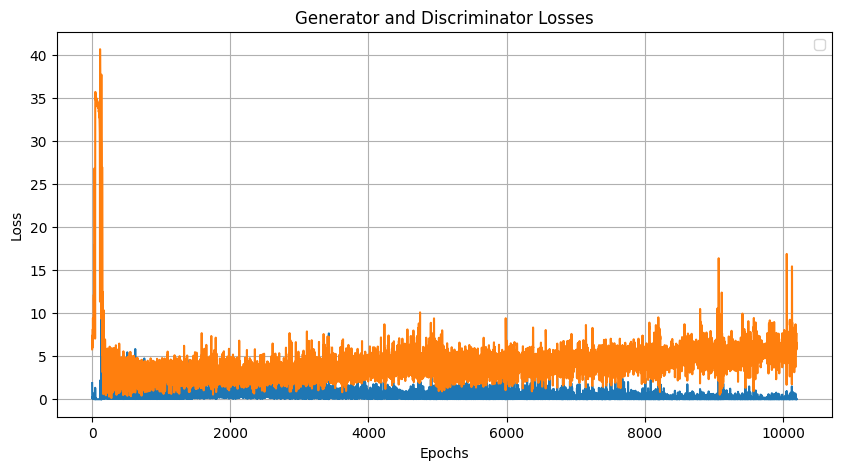

In [20]:
plt.figure(figsize=(10, 5))
plt.title('Generator and Discriminator Losses')
plt.plot(discrim_loss)
plt.plot(gen_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [21]:
import matplotlib.animation as animation
from IPython.display import HTML

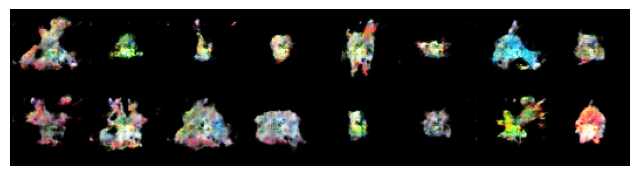

In [22]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
#ani.save('/content/drive/MyDrive/Colab Notebooks/PERSONAL PROJECTS/GANs/Pokemon/Pokemon_Epochs.mp4')
HTML(ani.to_jshtml())

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


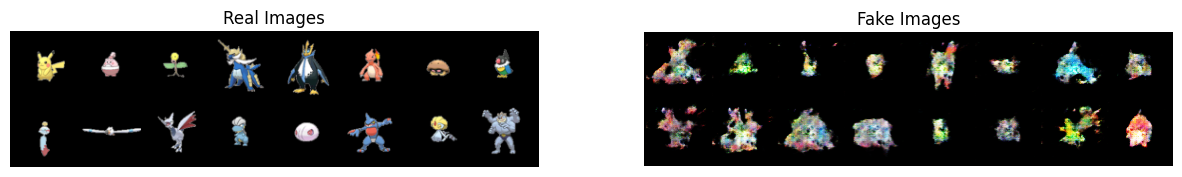

<Figure size 640x480 with 0 Axes>

In [30]:
# Grab a batch of real images from the dataloader
data,label = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(data.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/PERSONAL PROJECTS/GANs/Pokemon/pokemon_realvfake.png')
plt.show()


In [24]:
noise= torch.randn(64 , 100,1,1).to(device)
generated_data = generator(noise)


# plotting results

In [25]:
generated_data = generated_data.cpu().detach()


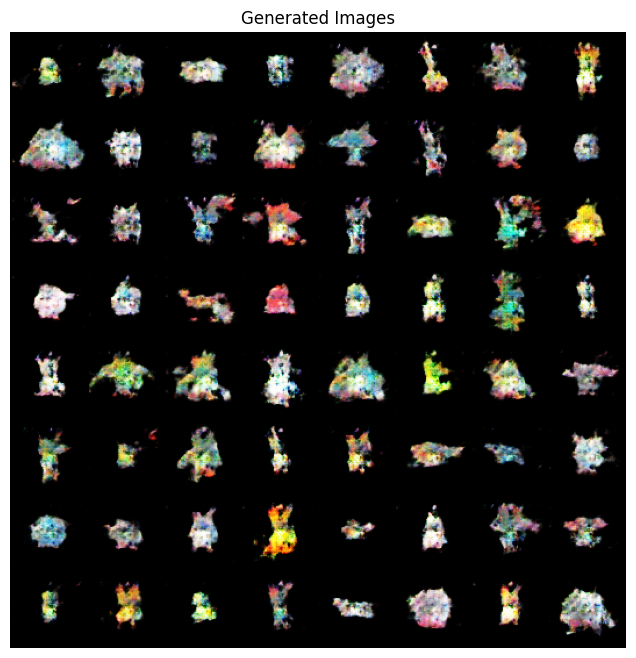

In [26]:
plt.figure(figsize= (8,8))
plt.axis('off')
plt.title('Generated Images')
plt.imshow(make_grid(generated_data, padding=2,normalize=True).permute(1,2,0).clip(0,1))
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/PERSONAL PROJECTS/GANs/Pokemon/pokemon_gen.png')

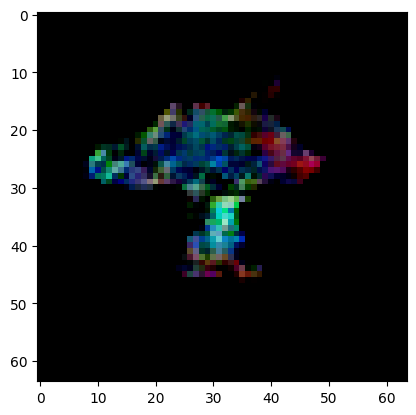

In [27]:
plt.imshow(generated_data[12].cpu().detach().clip(0,1).permute(1,2,0).numpy())

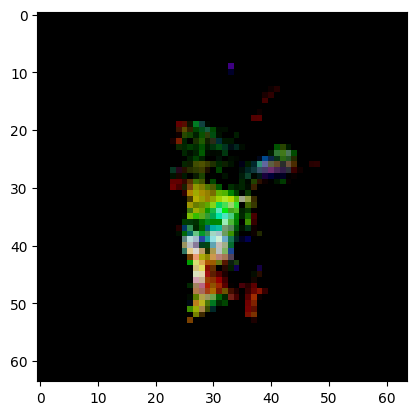

In [28]:
plt.imshow(generated_data[40].cpu().detach().clip(0,1).permute(1,2,0).numpy())

In [29]:
#torch.save(generator, '/content/drive/MyDrive/Colab Notebooks/PERSONAL PROJECTS/GANs/Pokemon/pokemon_generator.pth')